# Hierarchical Ar(1) on a Grid Test with compositional score matching

In this notebook, we will test the compositional score matching on a hierarchical problem defined on a grid.
- The observations are on grid with `n_grid` x `n_grid` points.
- The global parameters are the same for all grid points with hyper-priors:
$$ \alpha \sim \mathcal{N}(0, 1) \quad
  \mu_\beta \sim \mathcal{N}(0, 1) \quad
  \log\text{std}_\beta \sim \mathcal{N}(-1, 1);$$

- The local parameters are different for each grid point
$$ \beta_{i,j} \sim \mathcal{N}(\mu_\beta, \text{std}_\beta^2)$$

-  In each grid point, we have a time series of `T` observations. For the time beeing, we fix $\sigma=1$.
$$ y_{i,j} \sim \mathcal{N}(\alpha + \beta_{i,j}y_{i,j-1}, \sigma^2), y_{i,0} \sim \mathcal{N}(0, \sigma^2)$$
- We observe $T=10$ time points for each grid point. We can also amortize over the time dimension.

In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

os.environ['KERAS_BACKEND'] = 'torch'
from bayesflow import diagnostics

from torch.utils.data import DataLoader

from diffusion_model import HierarchicalScoreModel, SDE, euler_maruyama_sampling, adaptive_sampling, probability_ode_solving, langevin_sampling, generate_diffusion_time, train_score_model
from diffusion_model.helper_networks import LSTM
from problems.ar1_grid import AR1GridProblem, Prior
from problems import plot_shrinkage, visualize_simulation_output

with torch.enable_grad():
in contexts where you need gradients (e.g. custom training loops).
/home/jonas/PyCharmProjects/hierarchical-abi/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
DEBUG:cmdstanpy:found newer exe file, not recompiling


In [2]:
torch_device = torch.device("cuda")

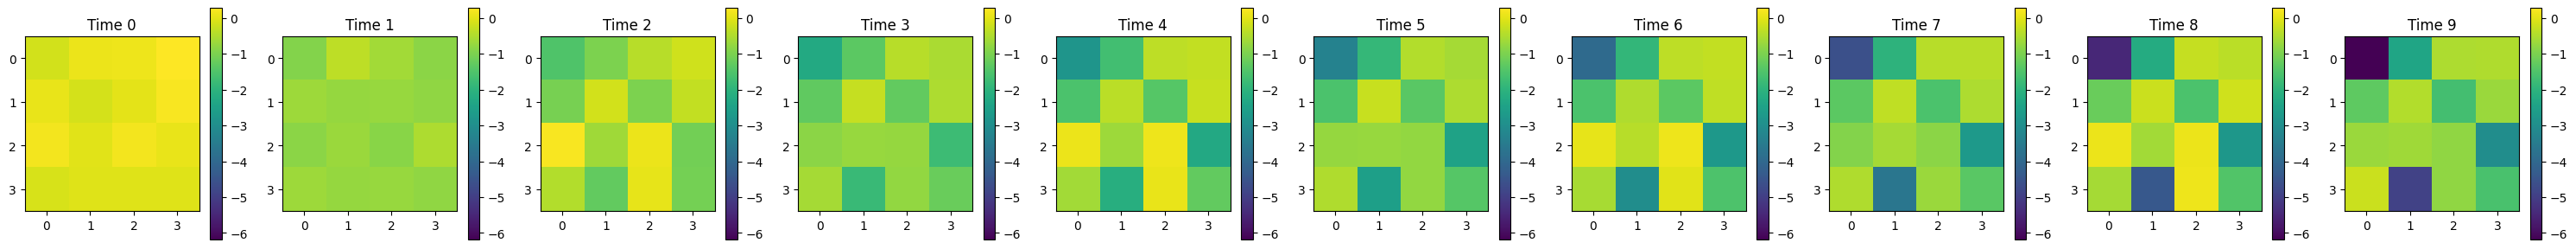

In [3]:
prior = Prior()

# test the simulator
sim_test = prior.sample(1, n_local_samples=16, get_grid=True)['data'][0]
visualize_simulation_output(sim_test)

In [4]:
batch_size = 128
number_of_obs = 64 #[1, 2, 3, 4, 5]  # or a list
current_sde = SDE(
    kernel_type=['variance_preserving', 'sub_variance_preserving'][0],
    noise_schedule=['linear', 'cosine', 'flow_matching'][1]
)

dataset = AR1GridProblem(
    n_data=10000,
    prior=prior,
    sde=current_sde,
    online_learning=True,
    number_of_obs=number_of_obs,
    amortize_time=False
)

dataset_valid = AR1GridProblem(
    n_data=1000,
    prior=prior,
    sde=current_sde,
    number_of_obs=number_of_obs,
    rectified_flow=True
)

# Create dataloader
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

for test in dataloader:
    print(test[2].shape)
    break

Kernel type: variance_preserving, noise schedule: cosine
t_min: 0.00035210439818911254, t_max: 0.999647855758667
alpha, sigma: (tensor(1.0000), tensor(0.0006)) (tensor(0.0006), tensor(1.0000))
Moving prior to device: cpu
torch.Size([128, 64, 1])


In [5]:
# Define diffusion model
summary_net = LSTM(input_size=1, hidden_dim=256)

score_model = HierarchicalScoreModel(
    input_dim_theta_global=prior.n_params_global,
    input_dim_theta_local=prior.n_params_local,
    input_dim_x=256,
    summary_net=summary_net,
    hidden_dim=256,
    n_blocks=5,
    max_number_of_obs=number_of_obs if isinstance(number_of_obs, int) else max(number_of_obs),
    prediction_type=['score', 'e', 'x', 'v'][3],
    sde=current_sde,
    weighting_type=[None, 'likelihood_weighting', 'flow_matching', 'sigmoid'][1],
    prior=prior,
    name_prefix='AR1_'
)

# make dir for plots
if not os.path.exists(f"plots/{score_model.name}"):
    os.makedirs(f"plots/{score_model.name}")

+--------------------------------------+------------+
|               Modules                | Parameters |
+--------------------------------------+------------+
|   blocks.res_blocks.0.dense.weight   |   132352   |
|    blocks.res_blocks.0.dense.bias    |    256     |
| blocks.res_blocks.0.projector.weight |   132352   |
|   blocks.res_blocks.1.dense.weight   |   65536    |
|    blocks.res_blocks.1.dense.bias    |    256     |
|   blocks.res_blocks.2.dense.weight   |   65536    |
|    blocks.res_blocks.2.dense.bias    |    256     |
|   blocks.res_blocks.3.dense.weight   |   65536    |
|    blocks.res_blocks.3.dense.bias    |    256     |
|   blocks.res_blocks.4.dense.weight   |   65536    |
|    blocks.res_blocks.4.dense.bias    |    256     |
|    final_projection_linear.weight    |    768     |
|     final_projection_linear.bias     |     3      |
+--------------------------------------+------------+
Total Trainable Params: 528899
AR1_global_score_model_v_variance_preserving_cosine

In [ ]:
# train model
loss_history = train_score_model(score_model, dataloader, dataloader_valid=dataloader_valid, hierarchical=True,
                                              epochs=500, device=torch_device)
score_model.eval()
torch.save(score_model.state_dict(), f"models/{score_model.name}.pt")

# plot loss history
plt.figure(figsize=(16, 4), tight_layout=True)
plt.plot(loss_history[:, 0], label='Training', color="#132a70", lw=2.0, alpha=0.9)
plt.plot(loss_history[:, 1], label='Validation', linestyle="--", marker="o", color='black')
plt.grid(alpha=0.5)
plt.xlabel('Training epoch #')
plt.ylabel('Value')
plt.legend()
plt.savefig(f'plots/{score_model.name}/loss_training.png')

Training v-model for 500 epochs with learning rate 0.0005 and likelihood_weighting weighting.


In [ ]:
score_model.load_state_dict(torch.load(f"models/{score_model.name}.pt", weights_only=True))
score_model.eval();

# Validation

In [ ]:
n_grid = 4
np.random.seed(0)
prior_dict = prior.sample(batch_size=100, n_local_samples=n_grid*n_grid, get_grid=True)

valid_prior_global, valid_prior_local, valid_data = prior_dict['global_params'], prior_dict['local_params'], prior_dict['data']
n_post_samples = 10
global_param_names = prior.global_param_names
local_param_names = prior.get_local_param_names(n_grid*n_grid)
score_model.current_number_of_obs = 16  # we can choose here, how many observations are passed together through the score

In [ ]:
visualize_simulation_output(prior.normalize_data(valid_data[0]))

In [ ]:
visualize_simulation_output(valid_data[0])

In [ ]:
posterior_global_samples_valid = langevin_sampling(score_model, valid_data, n_post_samples=n_post_samples,
                                                   diffusion_steps=300, langevin_steps=5, step_size_factor=0.05,
                                                   device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_langevin_sampler.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_langevin_sampler.png')

In [ ]:
posterior_global_samples_valid = euler_maruyama_sampling(score_model, valid_data, n_post_samples=n_post_samples,
                                                        diffusion_steps=1000, device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sampler.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sampler.png')

In [ ]:
mini_batch_size = 10
t1_value = 0.1# /( (n_grid*n_grid) //score_model.current_number_of_obs)
t0_value = 1
mini_batch_arg = {
    'size': mini_batch_size,
    #'damping_factor': lambda t: t1_value + (t0_value - t1_value) * 0.5 * (1 + torch.cos(torch.pi * t)),
    #'damping_factor': lambda t: t0_value + (t1_value - t0_value) * score_model.sde.kernel(log_snr=score_model.sde.get_snr(t))[1],
    #'damping_factor': lambda t: 0.1, #t1_value,
    'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    'damping_factor_prior': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
    #'damping_factor': lambda t: t0_value + (t1_value - t0_value) * torch.sigmoid(20*(t-0.3))
}
#plt.plot(torch.linspace(0, 1, 100), mini_batch_arg['damping_factor'](torch.linspace(0, 1, 100)))
#plt.show()
score_model.sde.s_shift_cosine = 6

t0_value, t1_value

In [ ]:
posterior_global_samples_valid = euler_maruyama_sampling(score_model, valid_data,
                                                         n_post_samples=n_post_samples,
                                                         mini_batch_arg=mini_batch_arg,
                                                         diffusion_steps=300, device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_euler_sub_sampler.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_euler_sub_sampler.png')

In [ ]:
posterior_global_samples_valid = adaptive_sampling(score_model, valid_data, n_post_samples,
                                                   #mini_batch_arg=mini_batch_arg,
                                                   run_sampling_in_parallel=False,
                                                   device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_adaptive_sampler.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_adaptive_sampler.png')

In [ ]:
posterior_global_samples_valid = probability_ode_solving(score_model, valid_data, n_post_samples=n_post_samples,
                                                         run_sampling_in_parallel=False,
                                                         device=torch_device, verbose=True)

In [ ]:
fig = diagnostics.recovery(posterior_global_samples_valid, np.array(valid_prior_global), variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/recovery_global_ode.png')

fig = diagnostics.calibration_ecdf(posterior_global_samples_valid, np.array(valid_prior_global),
                          difference=True, variable_names=global_param_names)
fig.savefig(f'plots/{score_model.name}/ecdf_global_ode.png')

In [ ]:
conditions_global = (np.median(posterior_global_samples_valid, axis=0), posterior_global_samples_valid)[1]
posterior_local_samples_valid = euler_maruyama_sampling(score_model, valid_data,
                                                        n_post_samples=n_post_samples, conditions=conditions_global,
                                                        diffusion_steps=50, device=torch_device, verbose=True)

posterior_local_samples_valid = score_model.prior.transform_local_params(posterior_local_samples_valid)

In [ ]:
diagnostics.recovery(posterior_local_samples_valid.reshape(valid_data.shape[0], n_post_samples, -1),
                          np.array(valid_prior_local).reshape(valid_data.shape[0], -1),
                          variable_names=local_param_names);

In [ ]:
#conditions_global = np.median(posterior_global_samples_valid, axis=1)
posterior_local_samples_valid = probability_ode_solving(score_model, valid_data, n_post_samples=n_post_samples,
                                                        run_sampling_in_parallel=False,
                                                        conditions=posterior_global_samples_valid, device=torch_device, verbose=True)

posterior_local_samples_valid = score_model.prior.transform_local_params(posterior_local_samples_valid)

In [ ]:
diagnostics.recovery(posterior_local_samples_valid.reshape(valid_data.shape[0], n_post_samples, -1),
                          np.array(valid_prior_local).reshape(valid_data.shape[0], -1),
                          variable_names=local_param_names);

In [ ]:
valid_id = 2
print('Data')
visualize_simulation_output(valid_data[valid_id])
print('Global Estimates')
print('mu:', np.median(posterior_global_samples_valid[valid_id, :, 0]), np.std(posterior_global_samples_valid[valid_id, :, 0]))
print('log sigma:', np.median(posterior_global_samples_valid[valid_id, :, 1]), np.std(posterior_global_samples_valid[valid_id, :, 1]))
print('True')
print('mu:', valid_prior_global[valid_id][0].item())
print('log sigma:', valid_prior_global[valid_id][1].item())

In [ ]:
med = np.median(posterior_local_samples_valid[valid_id].reshape(n_post_samples, n_grid, n_grid), axis=0)
std = np.std(posterior_local_samples_valid[valid_id].reshape(n_post_samples, n_grid, n_grid), axis=0)
error = (med-valid_prior_local[valid_id].numpy())**2
visualize_simulation_output(np.stack((med, valid_prior_local[valid_id], )),
                            title_prefix=['Posterior Median', 'True'])

visualize_simulation_output(np.stack((std, error)), title_prefix=['Uncertainty', 'Error'], same_scale=False)


plt.figure(figsize=(4, 4), tight_layout=True)
plt.errorbar(x=valid_prior_local[valid_id].flatten(), y=med.flatten(), yerr=1.96*std.flatten(), fmt='o')
plt.plot([np.min(med), np.max(med)], [np.min(med), np.max(med)], 'k--')
plt.axhline(np.median(posterior_global_samples_valid[valid_id, :], axis=0)[0], color='red', linestyle='--',
            label='Global posterior mean', alpha=0.75)
plt.ylabel('Prediction')
plt.xlabel('True')
plt.legend()
plt.show()

# Compare to STAN

In [ ]:
global_posterior_stan = np.load('problems/ar1/global_posterior.npy')#[:, -100:]
local_posterior_stan = np.load('problems/ar1/local_posterior.npy')#[:, -100:]
true_global = np.load('problems/ar1/true_global.npy')
true_local = np.load('problems/ar1/true_local.npy')

n_grid_stan = int(np.sqrt(true_local.shape[1]))

test_data = []
for g, l in zip(true_global, true_local):
    sim_dict = {'alpha': g[0],
                'beta': l}
    td = prior.simulator(sim_dict)['observable']
    test_data.append(td.reshape(1, 10, n_grid_stan, n_grid_stan))
test_data = np.concatenate(test_data)
test_data.shape

In [ ]:
t0_value, t1_value = 1, 0.5
mini_batch_arg = {
    #'size': 10,
    'damping_factor': lambda t: t0_value * torch.exp(-np.log(t0_value / t1_value) * 2*t),
}
n_post_samples = 100
global_param_names = prior.global_param_names
local_param_names = prior.get_local_param_names(n_grid_stan*n_grid_stan)
param_names_stan = ['STAN '+ p for p in global_param_names]
score_model.sde.s_shift_cosine = 0

In [ ]:
score_model.sde.s_shift_cosine = 0
posterior_global_samples_test = adaptive_sampling(score_model, test_data, n_post_samples,
                                                   mini_batch_arg=mini_batch_arg,
                                                   run_sampling_in_parallel=False,
                                                   device=torch_device, verbose=True)

In [ ]:
score_model.sde.s_shift_cosine = 0
posterior_local_samples_test = euler_maruyama_sampling(score_model, test_data, n_post_samples,
                                                 conditions=posterior_global_samples_test,
                                                 #run_sampling_in_parallel=False,
                                                 diffusion_steps=50,
                                                 device=torch_device, verbose=True)

posterior_local_samples_test = score_model.prior.transform_local_params(posterior_local_samples_test)

In [ ]:
diagnostics.recovery(posterior_global_samples_test, true_global, variable_names=global_param_names)
#diagnostics.recovery(posterior_global_samples_test, np.median(global_posterior_stan, axis=1),
#                     variable_names=global_param_names, xlabel='STAN Median Estimate')
diagnostics.recovery(global_posterior_stan, true_global, variable_names=param_names_stan);

In [ ]:
diagnostics.calibration_ecdf(posterior_global_samples_test, true_global, difference=True,
                             variable_names=global_param_names)
diagnostics.calibration_ecdf(global_posterior_stan, true_global, difference=True, variable_names=param_names_stan);

In [ ]:
global_var = np.exp(np.median(posterior_global_samples_test, axis=1)[:, 1])[:, np.newaxis] ** 2
shrinkage = 1-np.var(np.median(posterior_local_samples_test, axis=1), axis=1)/global_var

global_var_stan = np.exp(np.median(global_posterior_stan, axis=1)[:, 1])**2
shrinkage_stan = 1-np.var(np.median(local_posterior_stan, axis=1), axis=1)/global_var_stan

true_var = np.exp(true_global)[:, 1]**2
shrinkage_true = 1-np.var(true_local, axis=1)/true_var

s_order = np.argsort(shrinkage_true)
shrinkage = shrinkage.flatten()[s_order]
shrinkage_stan = shrinkage_stan.flatten()[s_order]
shrinkage_true = shrinkage_true[s_order]

min_s = -10
shrinkage[shrinkage < min_s] = min_s
shrinkage_stan[shrinkage_stan < min_s] = min_s
shrinkage_true[shrinkage_true < min_s] = min_s

plt.title('Shrinkage')
plt.plot(shrinkage, label='score', alpha=0.75)
plt.plot(shrinkage_stan, label='STAN', alpha=0.75)
plt.plot(shrinkage_true, label='true', alpha=0.75)
plt.legend()
plt.show()

print('Correlation shrinkage score and STAN:', np.corrcoef(shrinkage, shrinkage_stan)[0, 1])
print('Correlation shrinkage true and score:', np.corrcoef(shrinkage_true, shrinkage)[0, 1])
print('Correlation shrinkage true and STAN:', np.corrcoef(shrinkage_true, shrinkage_stan)[0, 1])

print(f"Score shrinkage < STAN shrinkage: {(shrinkage < shrinkage_stan).sum() / shrinkage.shape[0]*100}%")

In [ ]:
diagnostics.recovery(posterior_local_samples_test.reshape(test_data.shape[0], n_post_samples, -1), true_local,
                     variable_names=local_param_names)
diagnostics.recovery(local_posterior_stan, true_local, variable_names=local_param_names);

In [ ]:
diagnostics.recovery(posterior_local_samples_test.reshape(test_data.shape[0], n_post_samples, -1),
                     np.median(local_posterior_stan, axis=1), ylabel='Score Based Estimates', xlabel='STAN Median Estimate');

In [ ]:
plot_shrinkage(posterior_global_samples_test[:10], posterior_local_samples_test[:, :, :, np.newaxis][:10], min_max=(-10,10))

In [ ]:
plot_shrinkage(global_posterior_stan[:10], local_posterior_stan[:, :, :, np.newaxis][:10], min_max=(-10,10))